# Partie 1
le code suivent permet de :
- Importé les libs
- Chargé les données
- Netoyé les données
- Cree le convertiseur NLP
- cree l'imputer de données manquante
- De definir la fonction pour les KPI
- De faire tourné la main loop afin d'ajouté les KPI a `clothes_df`


In [1]:
# Import

import string
from time import perf_counter

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, ColorPicker, Slider
from bokeh.layouts import row, column
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact

import spacy

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.impute import KNNImputer
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import OPTICS
from sklearn.cluster import MeanShift
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE

from minisom import MiniSom




import hdbscan

In [2]:
# Load
impacts_df = pd.read_csv('data.csv')
clothes_df = pd.read_csv('vetements copy.csv')

In [4]:
# Clean
impacts_df.fillna(0, inplace=True)
clothes_df.fillna(0, inplace=True)

null_col = []
for col in clothes_df.columns:
    to_del_col = True
    for line in clothes_df[col]:
        if line != 0.0:
            to_del_col = False
    if to_del_col:
        print(f'{col} -> max: {clothes_df[col].max()} | min: {clothes_df[col].min()}')
        null_col.append(col)

clothes_df.drop(null_col, axis = 1, inplace = True)

#print(impacts_df.info())
#print(clothes_df.info())

In [5]:
# NLP to convert materials into generic name
nlp = spacy.load('en_core_web_lg')

def convert_raw_material(raw_material):
    raw_material = raw_material.lower()
    raw_material = raw_material.strip()

    doc = nlp(raw_material)

    lemmas = [token.lemma_ for token in doc]

    best_match = None
    max_similarity = 0
    for material in impacts_df['Material']:
        similarity = nlp(material.lower()).similarity(doc)
        if similarity > max_similarity:
            best_match = material
            max_similarity = similarity

    if max_similarity > 0.6:
        #print(f"-- OK -- {raw_material} have been transform to {best_match}")
        return best_match
    else:
        #print(f"-- KO -- can't fine a better name for {raw_material}")
        return raw_material


In [6]:
# Null value imputer
def impute_missing_value(df, column_name, k=5):
    
    missing_values = df[column_name].values.reshape(-1,1)
    #print(f'missing -> {missing_values}')
    
    # KNNImputer
    knn_imputer = KNNImputer(n_neighbors=k)
    knn_imputed_values = knn_imputer.fit_transform(missing_values)
    
    # Linear Regression
    lr_imputer = LinearRegression()
    lr_imputed_values = missing_values.copy()
    lr_imputed_values[np.isnan(lr_imputed_values)] = 0 # set NaN values to 0
    non_missing_indices = np.where(~np.isnan(lr_imputed_values))[0] # get non-missing value indices
    X = non_missing_indices.reshape(-1,1)
    y = lr_imputed_values[non_missing_indices]
    lr_imputer.fit(X, y)
    lr_imputed_values[np.isnan(missing_values).ravel()] = lr_imputer.predict(np.isnan(missing_values).reshape(-1,1))
    
    # Mean imputation
    mean_imputed_values = missing_values.copy()
    mean = np.nanmean(mean_imputed_values)
    mean_imputed_values[np.isnan(mean_imputed_values)] = mean
    
    # Evaluate performance
    knn_mae = np.mean(abs(missing_values - knn_imputed_values))
    lr_mae = np.mean(abs(missing_values - lr_imputed_values))
    mean_mae = np.mean(abs(missing_values - mean_imputed_values))
    
    # Return imputed value with best performance
    if knn_mae <= lr_mae and knn_mae <= mean_mae:
        return knn_imputed_values[0][0]
    elif lr_mae <= mean_mae:
        return lr_imputed_values[0][0]
    else:
        return mean_imputed_values[0][0]


In [7]:
# V0 KPI calculatator
def calculate_kpis(row):

    impact_data = impacts_df.loc[impacts_df['Material'] == row]
    
    if impact_data.isnull().values.any():
        for col in impact_data.columns:
            if impact_data[col].isnull().values.any():
                imputed_value = impute_missing_value(impact_data, col)
                impact_data[col] = imputed_value
    
    
    env_score = (impact_data['Water_Use_kg/kg'] + impact_data['Fossil_Energy_kg/kg'] +
                 impact_data['Greenhouse_Gas_kgCO2eq/kg'] + impact_data['Land_use_m2/kg']) / 4
    
    animal_score = impact_data['Animal_Welfare_Score']
    
    
    human_score = impact_data['Human_Welfare_Score']
    
    
    social_score = (1 if impact_data['Labor_Conditions'].eq("unsafe").any() else 10+ 
                    impact_data['Human_Welfare_Score']) / 2

    kpis = {'Environmental Impact Score': float(env_score),
            'Animal Welfare Score': float(animal_score),
            'Human Welfare Score': float(human_score),
            'Social Responsibility Score': float(social_score)}
    
    return kpis


In [8]:
# V1 KPI calculator
def normalize_value(value, min_value, max_value, new_min=0, new_max=10):
    out = new_min + ((value - min_value) * (new_max - new_min)) / (max_value - min_value)
    return out

def calculate_kpis(row):

    impact_data = impacts_df.loc[impacts_df['Material'] == row]
    
    if impact_data.isnull().values.any():
        for col in impact_data.columns:
            if impact_data[col].isnull().values.any():
                imputed_value = impute_missing_value(impact_data, col)
                impact_data[col] = imputed_value
    
    env_score = (impact_data['Water_Use_kg/kg'] + impact_data['Fossil_Energy_kg/kg'] +
                 impact_data['Greenhouse_Gas_kgCO2eq/kg'] + impact_data['Land_use_m2/kg']) / 4
    
    animal_score = impact_data['Animal_Welfare_Score']
    human_score = impact_data['Human_Welfare_Score']
    social_score = (1 if impact_data['Labor_Conditions'].eq("unsafe").any() else 10 + 
                    impact_data['Human_Welfare_Score']) / 2

    # Define the minimum and maximum values for each KPI
    env_min, env_max = 0, 58
    animal_min, animal_max = 0, 5
    human_min, human_max = 0, 5
    social_min, social_max = 0, 5

    # Normalize the KPI values to a range of 0-10
    env_score_normalized = normalize_value(float(env_score), env_min, env_max)
    animal_score_normalized = normalize_value(float(animal_score), animal_min, animal_max)
    human_score_normalized = normalize_value(float(human_score), human_min, human_max)
    social_score_normalized = normalize_value(float(social_score), social_min, social_max)

    kpis = {'Environmental Impact Score': env_score_normalized,
            'Animal Welfare Score': animal_score_normalized,
            'Human Welfare Score': human_score_normalized,
            'Social Responsibility Score': social_score_normalized}
    
    return kpis


In [9]:
# Main KPI Loops
times = []
for idx, raw in clothes_df.iterrows():
    kpis_row = []
    final = {}
    start_time = perf_counter()
    for col, value in raw.items():
        if (value not in [0, 0.0]) and (col != "Type"):
            kpis = calculate_kpis(convert_raw_material(col))
            pond_kpis = {}
            for k, v in kpis.items():
                pond_kpis[k] = v * value
            kpis_row.append(pond_kpis)
    
    for i in kpis_row:
        for k, v in i.items():
            final[k] = final.get(k, 0) + (v/len(kpis_row))
    for k, v in final.items():
        if k not in clothes_df.columns:
            clothes_df[k] = 0
        clothes_df.loc[idx, k] = round(v, 2)
    if idx % 10 == 0:
        print(f'Index {idx} done. Total {len(clothes_df)}. Percentage -> {(idx / len(clothes_df)):.2%}')
    times.append(perf_counter() - start_time)

print(clothes_df)
print(f'mean time per row -> {(sum(times)/len(times)):.2f} s')
print(f'max time per row -> {max(times):.2f} s')
print(f'min time per row -> {min(times):.2f} s')
print(f'total time -> {sum(times):.2f} s')

/var/folders/86/3wbmdrt94zqg6sdjxhcd3lv80000gn/T/ipykernel_78534/1625114689.py:15: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity = nlp(material.lower()).similarity(doc)
/var/folders/86/3wbmdrt94zqg6sdjxhcd3lv80000gn/T/ipykernel_78534/1625114689.py:15: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity = nlp(material.lower()).similarity(doc)


Index 0 done. Total 718. Percentage -> 0.00%
Index 10 done. Total 718. Percentage -> 1.39%
Index 20 done. Total 718. Percentage -> 2.79%
Index 30 done. Total 718. Percentage -> 4.18%
Index 40 done. Total 718. Percentage -> 5.57%
Index 50 done. Total 718. Percentage -> 6.96%
Index 60 done. Total 718. Percentage -> 8.36%
Index 70 done. Total 718. Percentage -> 9.75%
Index 80 done. Total 718. Percentage -> 11.14%
Index 90 done. Total 718. Percentage -> 12.53%
Index 100 done. Total 718. Percentage -> 13.93%
Index 110 done. Total 718. Percentage -> 15.32%
Index 120 done. Total 718. Percentage -> 16.71%
Index 130 done. Total 718. Percentage -> 18.11%
Index 140 done. Total 718. Percentage -> 19.50%
Index 150 done. Total 718. Percentage -> 20.89%
Index 160 done. Total 718. Percentage -> 22.28%
Index 170 done. Total 718. Percentage -> 23.68%
Index 180 done. Total 718. Percentage -> 25.07%
Index 190 done. Total 718. Percentage -> 26.46%
Index 200 done. Total 718. Percentage -> 27.86%
Index 210 d

# Partie 2
Le code suivant permet de visualisé le dataset dans ca globalité grace a: 
- Un plot 2D affichant a densité des données avec une reduction de dimentionalité (t-SNE)
- 4 polot 3D affichant des cluster colorié en fonction des KPI avec une reduction de dimentionalité (t-SNE)
- Un plot de coordonée parallel afin de l'ensemble des variable de mon dataset

In [15]:
#2D plot TSNE
df = clothes_df.drop(['Type', 'Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score'], axis=1)

tsne = TSNE(n_components=2, random_state=42)
transformed_data = tsne.fit_transform(df)

# Créer un DataFrame avec les données transformées
tsne_df = pd.DataFrame(transformed_data, columns=['t-SNE 1', 't-SNE 2'])

p = figure(match_aspect=True, tools="wheel_zoom,reset")
p.background_fill_color = '#440154'
p.grid.visible = False

p.hexbin(tsne_df['t-SNE 1'], tsne_df['t-SNE 2'], size=10, hover_color="pink", hover_alpha=0.8)

hover = HoverTool(tooltips=[("count", "@c"), ("(q,r)", "(@q, @r)")])
p.add_tools(hover)

show(p)

In [16]:
#3D plot TSNE
df = clothes_df.drop(['Type', 'Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score'], axis=1)

tsne = TSNE(n_components=3, random_state=42)
transformed_data = tsne.fit_transform(df)

# Créer un DataFrame avec les données transformées
tsne_df = pd.DataFrame(transformed_data, columns=['t-SNE 1', 't-SNE 2', 't-SNE 3'])

# Ajouter les colonnes de scores au DataFrame tsne_df
score_columns = ['Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score']
tsne_df[score_columns] = clothes_df[score_columns]

# Créer et afficher des graphiques séparés pour chaque KPI
for score in score_columns:
    fig = px.scatter_3d(tsne_df, x='t-SNE 1', y='t-SNE 2', z='t-SNE 3',
                        color=score, color_continuous_scale='Viridis', opacity=0.7,
                        title=f"Visualisation du dataset avec t-SNE (3D) - {score}")
    fig.show()

In [33]:
# Parallel Coordinates
# ... (chargement et normalisation des données)
plotly.io.orca.config.executable = '/path/to/orca'
def create_parallel_coordinates_plot(color_column):
    # Créez une palette de couleurs prédéfinie (du violet au orange)
    colorscale = px.colors.sequential.Viridis
    
    # Normalisez la colonne sélectionnée pour les couleurs
    color_values = (normalized_df[color_column] - normalized_df[color_column].min()) / \
                   (normalized_df[color_column].max() - normalized_df[color_column].min())
    
    fig = go.Figure()

    for index, row in normalized_df.iterrows():
        color_index = int(color_values.loc[index] * (len(colorscale) - 1))
        fig.add_trace(
            go.Scatter(
                x=target_columns,
                y=row,
                mode="lines",
                line=dict(color=colorscale[color_index], width=0.5),
                opacity=0.1,
                showlegend=False
            )
        )

    # Personnaliser les axes
    fig.update_xaxes(
        tickangle=90,  # Régler l'angle des étiquettes des axes à 90 degrés (vertical)
        tickfont=dict(size=10),  # Changer la taille de la police des étiquettes des axes
        title_font=dict(size=12),  # Changer la taille de la police des titres des axes
        tickcolor="gray",  # Changer la couleur des graduations des axes
        showgrid=True,  # Afficher la grille
        gridcolor="lightgray",  # Changer la couleur de la grille
    )

    fig.update_yaxes(
        tickfont=dict(size=10),  # Changer la taille de la police des étiquettes des axes
        title_font=dict(size=12),  # Changer la taille de la police des titres des axes
        tickcolor="gray",  # Changer la couleur des graduations des axes
        showgrid=True,  # Afficher la grille
        gridcolor="lightgray",  # Changer la couleur de la grille
        tickvals=[]  # Supprimer les échelles des axes
    )

    # Personnaliser l'apparence du graphique
    fig.update_layout(
        title=dict(
            text="Diagramme parallèle (Parallel Coordinates) du dataset",
            font=dict(size=18)
        ),
        plot_bgcolor="white",  # Changer la couleur de fond du graphique
        width=800,
        height=500,
        margin=dict(l=100, r=100, t=100, b=100)  # Ajuster l'espacement entre les axes et les bords du graphique
    )

    fig.write_image('test.svg', engine='orca')
    fig.show()

# Créez un widget Dropdown pour sélectionner la colonne de couleur
interact(create_parallel_coordinates_plot, color_column=target_columns)


interactive(children=(Dropdown(description='color_column', options=('Cotton', 'Organic_cotton', 'Linen', 'Hemp…

<function __main__.create_parallel_coordinates_plot(color_column)>

# Partie 3

In [25]:
#Clustering

features = clothes_df.iloc[:, -4:]
scaler = StandardScaler()
features = scaler.fit_transform(features)
['KMeanCluster', 'DbscanCluster', 'GMCluster', 'AggCluster', 'SpectralCluster', 'SpectralCluster', 'OpticsCluster', 'MeanShiftCluster', 'AffinityPropCluster', 'BirchCluster', 'SOMCluster', 'HDBSCANCluster']
#Elboy pour trouvé le best nombre de class
#K medoid 
#GMM Model pour annalysé le dataset -> graph 2,5D
#Kmean 

#KMean
kmeans = KMeans(n_clusters=2)
kmeans.fit(features)
predictions = kmeans.predict(features)
clothes_df["KMeanCluster"] = predictions

#DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(features)
predictions = dbscan.labels_
clothes_df["DbscanCluster"] = predictions

#GaussianMixture
gmm = GaussianMixture(n_components=2)
gmm.fit(features)
predictions = gmm.predict(features)
clothes_df["GMCluster"] = predictions

# Agglomerative Hierarchical Clustering
agg_clustering = AgglomerativeClustering(n_clusters=2, linkage="ward")
predictions = agg_clustering.fit_predict(features)
clothes_df["AggCluster"] = predictions

# Spectral Clustering
spectral_clustering = SpectralClustering(n_clusters=2, affinity="nearest_neighbors")
predictions = spectral_clustering.fit_predict(features)
clothes_df["SpectralCluster"] = predictions

# OPTICS
optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)
predictions = optics.fit_predict(features)
clothes_df["OpticsCluster"] = predictions

# Mean Shift Clustering
mean_shift = MeanShift(bandwidth=None, bin_seeding=True)
predictions = mean_shift.fit_predict(features)
clothes_df["MeanShiftCluster"] = predictions

# Affinity Propagation
affinity_propagation = AffinityPropagation(random_state=42)
predictions = affinity_propagation.fit_predict(features)
clothes_df["AffinityPropCluster"] = predictions

# Birch
birch = Birch(n_clusters=2, threshold=0.5, branching_factor=50)
predictions = birch.fit_predict(features)
clothes_df["BirchCluster"] = predictions

# Self-Organizing Map
som_grid_rows, som_grid_columns = 2, 2
som = MiniSom(som_grid_rows, som_grid_columns, features.shape[1], sigma=1.0, learning_rate=0.5, random_seed=42)
som.train_random(features, num_iteration=1000)
predictions = [som.winner(x) for x in features]
clothes_df["SOMCluster"] = predictions

# HDBSCAN
hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
predictions = hdbscan_cluster.fit_predict(features)
clothes_df["HDBSCANCluster"] = predictions





/Users/clem/Documents/Fast_fashion data/My own/projetIA/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/clem/Documents/Fast_fashion data/My own/projetIA/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/Users/clem/Documents/Fast_fashion data/My own/projetIA/lib/python3.11/site-packages/sklearn/cluster/_optics.py:932: RuntimeWarning:

divide by zero encountered in divide

/Users/clem/Documents/Fast_fashion data/My own/projetIA/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



AggCluster en cours
generation des plots
images/Agg_radar.png


/var/folders/86/3wbmdrt94zqg6sdjxhcd3lv80000gn/T/ipykernel_78534/298195471.py:14: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/var/folders/86/3wbmdrt94zqg6sdjxhcd3lv80000gn/T/ipykernel_78534/298195471.py:14: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



ValueError: Failed to start Kaleido subprocess. Error stream:

/Users/clem/Documents/Fast_fashion data/My own/projetIA/lib/python3.11/site-packages/kaleido/executable/kaleido: line 4: cd: /Users/clem/Documents/Fast_fashion: No such file or directory
/Users/clem/Documents/Fast_fashion data/My own/projetIA/lib/python3.11/site-packages/kaleido/executable/kaleido: line 5: ./bin/kaleido: No such file or directory


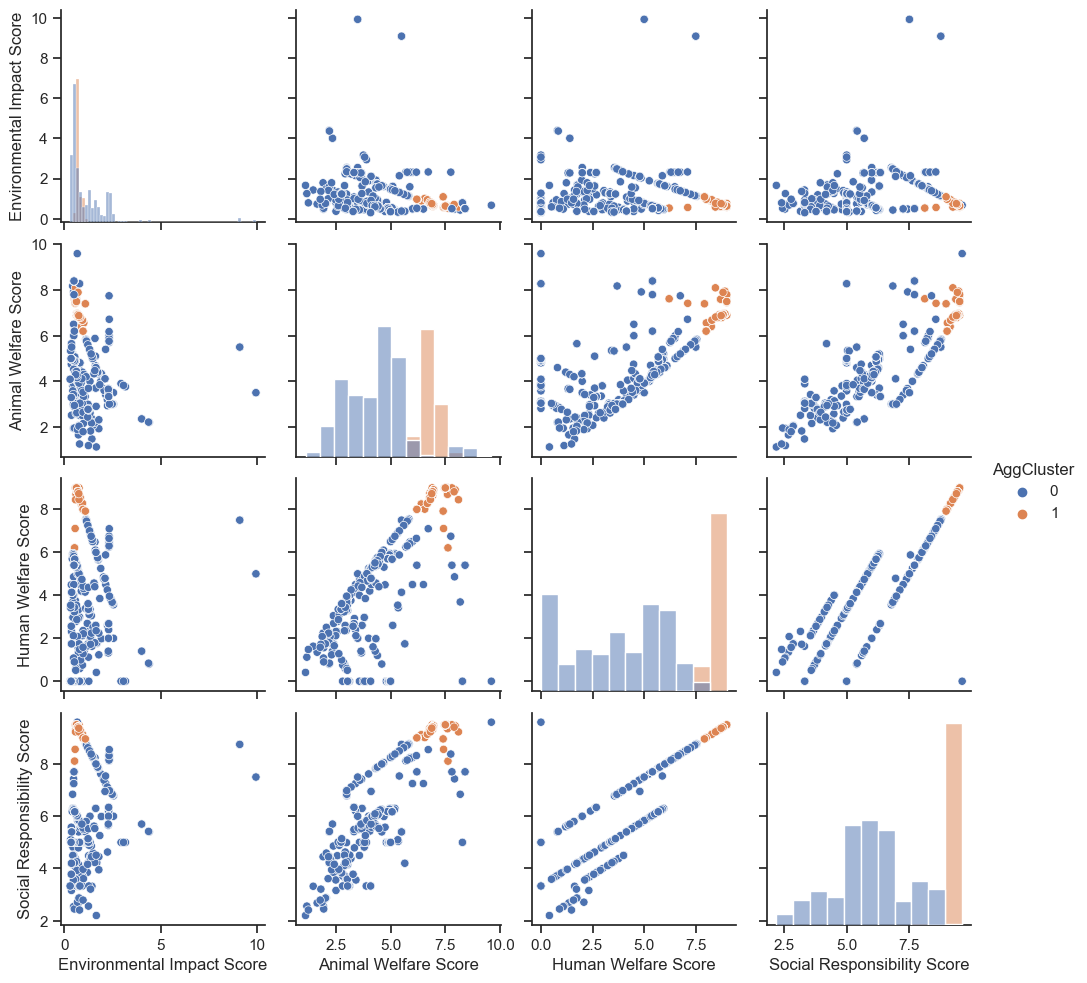

In [27]:
#Audi cluster
def ultimate_clustered(cluster):
    print(f'{cluster} en cours')
    
    print(f'generation des plots')
    sns.set(style="ticks", color_codes=True)
    sns.pairplot(data=clothes_df, vars=['Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score'], hue=cluster, diag_kind='hist')
    plt.savefig(f"images/{cluster.replace('Cluster','')}_pairplot.png", dpi=300)
    
    fig = go.Figure()
    for i in range(len(clothes_df[cluster].unique())):
        cluster_df = clothes_df[clothes_df[cluster] == i]
        fig.add_trace(go.Scatterpolar(
            r=cluster_df.mean()[['Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score']].tolist(),
            theta=['Environmental Impact', 'Animal Welfare', 'Human Welfare', 'Social Responsibility'],
            fill='toself',
            name=f'Cluster {i}'
        ))
    fig.update_layout(
        polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 10]
        )),
        showlegend=True
    )
    print(f"images/{cluster.replace('Cluster','')}_radar.png")
    fig.write_image(f"images/{cluster.replace('Cluster','')}_radar.png")
    fig.show()
    
    kmeans_means = clothes_df.groupby(cluster).mean()[['Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score']]
    kmeans_means.plot(kind='bar')
    plt.title(f'Mean KPI Scores by {cluster}')
    plt.savefig(f"images/{cluster.replace('Cluster','')}_histo.png", dpi=300)

    


clusters = ['KMeanCluster', 'DbscanCluster', 'GMCluster', 'AggCluster', 'SpectralCluster', 'SpectralCluster', 'OpticsCluster', 'MeanShiftCluster', 'AffinityPropCluster', 'BirchCluster', 'SOMCluster', 'HDBSCANCluster']
cluster = clusters[3]
ultimate_clustered(cluster)

In [ ]:
# Intern KPI of cluster
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Génération de données pour l'exemple
X, y = make_blobs(n_samples=500, centers=4, random_state=42)

# Exemple de clustering avec KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
y_pred = kmeans.fit_predict(X)

# Calcul du coefficient de silhouette
silhouette_avg = silhouette_score(X, y_pred)
silhouette_indicator = "bon" if silhouette_avg > 0.5 else "mauvais"
print(f"Coefficient de silhouette : {silhouette_avg} ({silhouette_indicator})")

# Calcul de l'indice de Davies-Bouldin
dbi = davies_bouldin_score(X, y_pred)
dbi_indicator = "bon" if dbi < 0.5 else "mauvais"
print(f"Indice de Davies-Bouldin : {dbi} ({dbi_indicator})")

# Calcul de l'indice de Calinski-Harabasz
ch_score = calinski_harabasz_score(X, y_pred)
ch_indicator = "bon" if ch_score > (len(X) / 2) else "mauvais"
print(f"Indice de Calinski-Harabasz : {ch_score} ({ch_indicator})")

#Nethode elbow
#kullerback 
# Attribution d'un score global au modèle en se basant sur les 3 méthodes
total_score = (
    (silhouette_avg - 0.5) / 0.5 +
    (1 - dbi) +
    (ch_score - len(X) / 2) / (len(X) / 2)
)
total_score /= 3
print(f"Score global du modèle : {total_score}")


In [ ]:
# Get non null kpi data
nonzero_rows = clothes_df[
    (clothes_df['Environmental Impact Score'] != 0.00) |
    (clothes_df['Animal Welfare Score'] != 0.00) |
    (clothes_df['Human Welfare Score'] != 0.00) |
    (clothes_df['Social Responsibility Score'] != 0.00)
]

# Print the selected rows, along with the other columns
print(nonzero_rows[['Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score', cluster]].head(600).to_csv(index=False))


In [ ]:
#PairPlot

sns.set(style="ticks", color_codes=True)
sns.pairplot(data=clothes_df, vars=['Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score'], hue=cluster, diag_kind='hist')


In [ ]:
#Radar

fig = go.Figure()
def radar(cluster):
  for i in range(len(clothes_df[cluster].unique())):
      cluster_df = clothes_df[clothes_df[cluster] == i]
      fig.add_trace(go.Scatterpolar(
          r=cluster_df.mean()[['Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score']].tolist(),
          theta=['Environmental Impact', 'Animal Welfare', 'Human Welfare', 'Social Responsibility'],
          fill='toself',
          name=f'Cluster {i}'
      ))

  fig.update_layout(
    polar=dict(
      radialaxis=dict(
        visible=True,
        range=[0, 10]
      )),
    showlegend=True
  )

  fig.show()

radar(cluster)
#radar('DbscanCluster')
#radar('GMCluster')


In [ ]:
#Bars

# Bar plot of mean KPI scores by cluster
kmeans_means = clothes_df.groupby(cluster).mean()[['Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score']]
kmeans_means.plot(kind='bar')
plt.title(f'Mean KPI Scores by {cluster}')
plt.show()
